# 원 베이스라인 코드 실행과 분석

## 데이터 불러오기

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
print("Dataset path:", path)

Dataset path: C:\Users\daboi\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2


In [2]:
import torch
import os
from torchvision import datasets
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import collections
from torch.utils.data import ConcatDataset, DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import precision_score, recall_score, f1_score

# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
# 'path' 변수에 저장된 기본 경로를 사용하여 데이터셋 경로 설정
train_dir = os.path.join(path, "chest_xray", "train")
val_dir = os.path.join(path, "chest_xray", "val")
test_dir = os.path.join(path, "chest_xray", "test")

In [4]:
transforms = v2.Compose(
    [
        v2.Resize((224, 224)),
        v2.ToImage(),
        v2.ToDtype(dtype=torch.float32, scale=True),
    ]
)

# 데이터셋 로드
train_dataset = datasets.ImageFolder(train_dir, transform=transforms)

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 클래스 확인
class_names = train_dataset.classes
print("Class names:", class_names)

Class names: ['NORMAL', 'PNEUMONIA']


2가지의 클래스가 있다

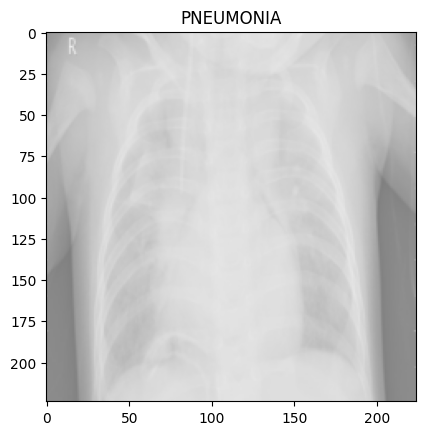

In [5]:
# 데이터 로더에서 배치 가져오기
images, labels = next(iter(train_loader))

# 이미지 시각화용 함수
def imshow(img, title):
    img = img / 2 + 0.5 # 정규화 복원을 해준다 matplotlib는 0~1사이의 값을 받기 때문이다
    npimg = img.numpy() # numpy로 변환 이 역시 matplotlib는 numpy를 받기 때문이다
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # (C, H, W) -> (H, W, C)로 변환 이 역시 matplotlib는 (H, W, C)를 받기 때문이다
    plt.title(title)
    plt.show()

# 첫 번째 배치의 첫 번째 이미지 시각화
imshow(images[0], title = class_names[labels[0]])

이까지는 데이터를 맛보기로 하나 불러와서 시각화를 해서 어떤 데이터인지 확인하는 과정이었고 이제 본격적으로 시작한다

In [6]:
# 데이터 전처리 정의
data_transforms = {
    'train': v2.Compose([
        v2.Resize((224, 224)),               # 이미지 크기 조정
        v2.RandomCrop((200, 200)),           # 랜덤 크롭 (200x200)
        v2.RandomRotation(20),               # 랜덤 회전 (-20도 ~ 20도)
        v2.ToTensor(),                       # 텐서로 변환
        v2.Normalize([0.5], [0.5])           # 정규화
    ]),
    'val': v2.Compose([
        v2.Resize((224, 224)),               # 이미지 크기 조정
        v2.ToTensor(),                       # 텐서로 변환
        v2.Normalize([0.5], [0.5])           # 정규화
    ]),
    'test': v2.Compose([
        v2.Resize((224, 224)),               # 이미지 크기 조정
        v2.ToTensor(),                       # 텐서로 변환
        v2.Normalize([0.5], [0.5])           # 정규화
    ])
}

C:\Users\daboi\PycharmProjects\PythonProject1\.venv\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [7]:
# 데이터셋 로드
train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
val_dataset = datasets.ImageFolder(val_dir, transform=data_transforms['val'])
test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms['test'])

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

Number of training samples: 5216
Number of validation samples: 16
Number of test samples: 624


val 데이터의 개수가 매우 적다 점수가 크게 출렁일 수 있을 것 같다

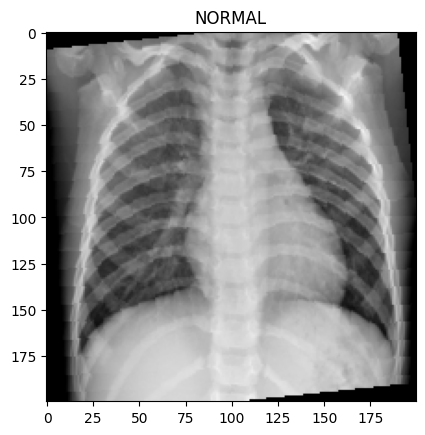

In [8]:
# 데이터 로더에서 배치 가져오기 (train)
images, labels = next(iter(train_loader))

# 이미지를 디스플레이
def imshow(img, title):
    img = img / 2 + 0.5  # 정규화 복원
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

# 첫 번째 배치의 첫 번째 이미지 시각화
imshow(images[0], title=class_names[labels[0]])

transform에서 RandomCrop과 RandomRotation이 추가된 것을 볼 수 있다

## Custom CNN 모델 정의

베이스라인 코드에서는 일단 그냥 간단한 CNN 모델로 시작해서 뒤의 모델들과 비교를 해본다

In [9]:
# Custom CNN 모델 정의
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)  # 입력 채널: 3, 출력 채널: 32
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)                  # MaxPooling
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1) # Conv2D
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))                       # Adaptive Pooling (7x7)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)                             # Fully Connected Layer
        self.fc2 = nn.Linear(128, num_classes)                            # Output Layer

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Conv1 + Pooling
        x = self.pool(F.relu(self.conv2(x)))  # Conv2 + Pooling
        x = self.avgpool(x)                   # Adaptive Pooling
        x = torch.flatten(x, 1)               # Flattening
        x = F.relu(self.fc1(x))               # Fully Connected Layer 1
        x = self.fc2(x)                       # Output Layer
        return x

# 클래스 수 설정 (NORMAL, PNEUMONIA)
num_classes = len(class_names)

In [10]:
# 모델, 손실 함수, 옵티마이저 설정
model = CustomCNN(num_classes).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

## 모델 학습 및 평가

In [11]:
# 학습 함수
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    step = 0
    for epoch in range(num_epochs):
        model.train()  # 모델을 학습 모드로 설정
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            # 데이터를 GPU/CPU로 이동
            inputs, labels = inputs.to(device), labels.to(device)

            # 이전 그래디언트 초기화
            optimizer.zero_grad()

            # Forward Pass
            outputs = model(inputs)

            # 손실 계산
            loss = criterion(outputs, labels)
            loss.backward()  # Backward Pass

            # 가중치 업데이트
            optimizer.step()

            running_loss += loss.item()

            # 정확도 계산
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            step += 1

        # 학습 손실 및 정확도 출력
        avg_train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        # 검증 단계 수행
        val_loss, val_acc = evaluate(model, val_loader, criterion)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

In [12]:
# 평가 함수
def evaluate(model, dataloader, loss_fn):
    model.eval()

    losses = []  # 손실값을 저장할 리스트
    correct = 0  # 올바르게 예측한 샘플 수
    total = 0    # 전체 샘플 수

    with torch.no_grad():
        for inputs, labels in dataloader:
            # 데이터를 GPU 또는 CPU로 이동
            inputs, labels = inputs.to(device), labels.to(device)

            # 모델의 예측값 계산
            outputs = model(inputs)

            # 손실값 계산
            loss = loss_fn(outputs, labels)
            losses.append(loss.item())

            # 예측값 가져오기
            pred_labels = torch.argmax(outputs, dim = 1)  # [배치 크기]
            correct += (pred_labels == labels).sum().item()
            total += labels.size(0)

    # 평균 손실값과 정확도 계산
    avg_loss = sum(losses) / len(losses)
    accuracy = correct / total

    return avg_loss, accuracy

In [13]:
# 학습 실행
train(model, train_loader, val_loader, loss_fn, optimizer, num_epochs = 10)

Epoch 1/10, Train Loss: 0.3334, Train Acc: 0.8518, Val Loss: 1.2715, Val Acc: 0.6250
Epoch 2/10, Train Loss: 0.1991, Train Acc: 0.9210, Val Loss: 0.7039, Val Acc: 0.6250
Epoch 3/10, Train Loss: 0.1669, Train Acc: 0.9360, Val Loss: 0.5781, Val Acc: 0.6875
Epoch 4/10, Train Loss: 0.1653, Train Acc: 0.9346, Val Loss: 1.2743, Val Acc: 0.6250
Epoch 5/10, Train Loss: 0.1532, Train Acc: 0.9404, Val Loss: 1.3974, Val Acc: 0.5625
Epoch 6/10, Train Loss: 0.1382, Train Acc: 0.9454, Val Loss: 0.6487, Val Acc: 0.6875
Epoch 7/10, Train Loss: 0.1271, Train Acc: 0.9507, Val Loss: 0.7345, Val Acc: 0.6875
Epoch 8/10, Train Loss: 0.1264, Train Acc: 0.9526, Val Loss: 1.0842, Val Acc: 0.5625
Epoch 9/10, Train Loss: 0.1194, Train Acc: 0.9548, Val Loss: 0.7798, Val Acc: 0.6250
Epoch 10/10, Train Loss: 0.1183, Train Acc: 0.9532, Val Loss: 0.8278, Val Acc: 0.6875


In [14]:
# 테스트 실행
test_loss, test_acc = evaluate(model, test_loader, loss_fn)

evaluate(model, test_loader, loss_fn)

(0.4659190232632682, 0.8509615384615384)

기본 CNN 모델
- Test Loss: 0.4659, Test Acc: 0.8509
- 기본 CNN 모델은 test score에서 그냥 보통의 성능을 보여주는 것 같다

## Transfer Learning

전이 학습을 시작한다

베이스라인 코드에서는 ResNet 모델을 사용했다

여기서는 분류기만 교체한다

In [15]:
# Pretrained ResNet 모델 로드
pretrained_model = models.resnet18(pretrained = True)

# Feature Extractor 동결 (파라미터 업데이트 불가)
for param in pretrained_model.parameters():
    param.requires_grad = False

# Classifier 교체 (기존 Fully Connected Layer를 새로운 Classifier로 교체)
num_features = pretrained_model.fc.in_features  # 기존 Fully Connected Layer 입력 크기
pretrained_model.fc = nn.Linear(num_features, num_classes)  # 새 출력층 생성
pretrained_model = pretrained_model.to(device)

C:\Users\daboi\PycharmProjects\PythonProject1\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\daboi\PycharmProjects\PythonProject1\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
print(pretrained_model.fc.weight.device)

cuda:0


In [17]:
# 손실 함수와 Optimizer 설정
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrained_model.parameters(), lr = 0.001)

# 학습 실행
train(pretrained_model, train_loader, val_loader, loss_fn, optimizer, num_epochs = 10)

# 테스트 실행
evaluate(pretrained_model, test_loader, loss_fn)

Epoch 1/10, Train Loss: 0.4132, Train Acc: 0.8173, Val Loss: 0.3590, Val Acc: 0.8750
Epoch 2/10, Train Loss: 0.2590, Train Acc: 0.8938, Val Loss: 0.3142, Val Acc: 0.8750
Epoch 3/10, Train Loss: 0.2211, Train Acc: 0.9118, Val Loss: 0.6640, Val Acc: 0.6875
Epoch 4/10, Train Loss: 0.2071, Train Acc: 0.9158, Val Loss: 0.3424, Val Acc: 0.8125
Epoch 5/10, Train Loss: 0.2022, Train Acc: 0.9166, Val Loss: 0.6300, Val Acc: 0.7500
Epoch 6/10, Train Loss: 0.1991, Train Acc: 0.9174, Val Loss: 0.5810, Val Acc: 0.7500
Epoch 7/10, Train Loss: 0.1864, Train Acc: 0.9266, Val Loss: 0.6777, Val Acc: 0.7500
Epoch 8/10, Train Loss: 0.1790, Train Acc: 0.9233, Val Loss: 0.7086, Val Acc: 0.6875
Epoch 9/10, Train Loss: 0.1843, Train Acc: 0.9225, Val Loss: 1.0141, Val Acc: 0.6250
Epoch 10/10, Train Loss: 0.1679, Train Acc: 0.9369, Val Loss: 0.6049, Val Acc: 0.7500


(0.44579155812971294, 0.8477564102564102)

전이 학습 ResNet 모델(분류기만 교체)
- Test Loss: 0.4457, Test Acc: 0.8477
- 분류기만 교체한 전이 학습 모델은 점수가 CNN과 비슷하다
- 지금 가장 큰 문제는 애초에 val 데이터가 너무 적어서 전체적인 점수가 신뢰할 수 없을 것 같다

## Transfer Learning (Partial Fine-Tuning)

부분 미세 조정에서는 모델의 마지막 몇 개 층만 학습 가능하도록 설정한다

In [18]:
# Pretrained ResNet 모델 로드
pretrained_model = models.resnet18(pretrained = True)

# Feature Extractor의 초기 층 동결
for name, param in pretrained_model.named_parameters():
    if "layer4" in name or "fc" in name:  # ResNet의 마지막 블록(layer4)와 Fully Connected Layer만 학습 가능
        param.requires_grad = True
    else:
        param.requires_grad = False

# Classifier 교체
num_features = pretrained_model.fc.in_features  # 기존 Fully Connected Layer 입력 크기
pretrained_model.fc = nn.Linear(num_features, num_classes)  # 새 출력층 생성

print("Trainable parameters:")
for name, param in pretrained_model.named_parameters():
    if param.requires_grad:
        print(name)

pretrained_model = pretrained_model.to(device)

Trainable parameters:
layer4.0.conv1.weight
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.conv2.weight
layer4.0.bn2.weight
layer4.0.bn2.bias
layer4.0.downsample.0.weight
layer4.0.downsample.1.weight
layer4.0.downsample.1.bias
layer4.1.conv1.weight
layer4.1.bn1.weight
layer4.1.bn1.bias
layer4.1.conv2.weight
layer4.1.bn2.weight
layer4.1.bn2.bias
fc.weight
fc.bias


학습을 하게되는 층들만 볼 수 있다 layer4와 fc층만 학습을 한다

In [19]:
# 손실 함수와 Optimizer 설정
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrained_model.parameters(), lr = 0.001)

# 학습 실행
train(pretrained_model, train_loader, val_loader, loss_fn, optimizer, num_epochs = 10)

# 테스트 실행
evaluate(pretrained_model, test_loader, loss_fn)

Epoch 1/10, Train Loss: 0.1382, Train Acc: 0.9475, Val Loss: 0.0985, Val Acc: 1.0000
Epoch 2/10, Train Loss: 0.0835, Train Acc: 0.9691, Val Loss: 0.1233, Val Acc: 0.9375
Epoch 3/10, Train Loss: 0.0762, Train Acc: 0.9722, Val Loss: 0.1024, Val Acc: 1.0000
Epoch 4/10, Train Loss: 0.0654, Train Acc: 0.9753, Val Loss: 0.1793, Val Acc: 0.9375
Epoch 5/10, Train Loss: 0.0581, Train Acc: 0.9780, Val Loss: 0.3468, Val Acc: 0.8125
Epoch 6/10, Train Loss: 0.0551, Train Acc: 0.9799, Val Loss: 0.0702, Val Acc: 1.0000
Epoch 7/10, Train Loss: 0.0491, Train Acc: 0.9824, Val Loss: 0.0565, Val Acc: 1.0000
Epoch 8/10, Train Loss: 0.0455, Train Acc: 0.9835, Val Loss: 0.2698, Val Acc: 0.8750
Epoch 9/10, Train Loss: 0.0453, Train Acc: 0.9854, Val Loss: 0.1866, Val Acc: 0.8750
Epoch 10/10, Train Loss: 0.0387, Train Acc: 0.9833, Val Loss: 0.1539, Val Acc: 0.8750


(0.4328564764524344, 0.8942307692307693)

전이 학습 ResNet 모델(부분 미세 조정)
- Test Loss: 0.4328, Test Acc: 0.8942
- 애초에 데이터 자체에 문제가 있는 것 같아서 사실 이 점수도 의미가 없어보인다

## Transfer Learning (Full Fine-Tuning)

모델의 모든 층을 학습 가능하도록 설정한다

In [20]:
# Pretrained ResNet 모델 로드
pretrained_model = models.resnet18(pretrained = True)

# 모든 층 학습 가능하도록 설정
for param in pretrained_model.parameters():
    param.requires_grad = True

# Classifier 교체
num_features = pretrained_model.fc.in_features  # 기존 Fully Connected Layer 입력 크기
pretrained_model.fc = nn.Linear(num_features, num_classes)  # 새 출력층 생성
pretrained_model = pretrained_model.to(device)

In [21]:
# 손실 함수와 Optimizer 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrained_model.parameters(), lr = 0.00001)  # Full Fine-Tuning에서는 더 낮은 학습률

In [22]:
# 학습 실행
train(pretrained_model, train_loader, val_loader, loss_fn, optimizer, num_epochs = 10)

# 테스트 실행
evaluate(pretrained_model, test_loader, loss_fn)

Epoch 1/10, Train Loss: 0.3290, Train Acc: 0.8576, Val Loss: 0.2385, Val Acc: 0.8750
Epoch 2/10, Train Loss: 0.1215, Train Acc: 0.9622, Val Loss: 0.2974, Val Acc: 0.8125
Epoch 3/10, Train Loss: 0.0946, Train Acc: 0.9668, Val Loss: 0.3587, Val Acc: 0.7500
Epoch 4/10, Train Loss: 0.0754, Train Acc: 0.9747, Val Loss: 0.4557, Val Acc: 0.7500
Epoch 5/10, Train Loss: 0.0633, Train Acc: 0.9783, Val Loss: 0.3419, Val Acc: 0.8125
Epoch 6/10, Train Loss: 0.0645, Train Acc: 0.9776, Val Loss: 0.2827, Val Acc: 0.8750
Epoch 7/10, Train Loss: 0.0561, Train Acc: 0.9812, Val Loss: 0.3687, Val Acc: 0.8750
Epoch 8/10, Train Loss: 0.0522, Train Acc: 0.9829, Val Loss: 0.1495, Val Acc: 0.8750
Epoch 9/10, Train Loss: 0.0452, Train Acc: 0.9845, Val Loss: 0.1986, Val Acc: 0.8750
Epoch 10/10, Train Loss: 0.0465, Train Acc: 0.9839, Val Loss: 0.1166, Val Acc: 1.0000


(0.32393546763341874, 0.8974358974358975)

전이 학습 ResNet 모델(전체 미세 조정)
- Test Loss: 0.3239, Test Acc: 0.8974
- 점수가 꽤 좋아졌지만 애초에 val 데이터가 너무 적어서 이때까지 돌린 모델들의 전체적인 점수를 신뢰할 수 없을 것 같다

In [23]:
# 훈련 데이터 클래스별 개수 계산
class_counts = collections.Counter(train_dataset.targets)

normal_idx = train_dataset.class_to_idx['NORMAL']
pneumonia_idx = train_dataset.class_to_idx['PNEUMONIA']

normal_count = class_counts[normal_idx]
pneumonia_count = class_counts[pneumonia_idx]

print("훈련 데이터 클래스별 개수:")
print(f"NORMAL: {normal_count} 개")
print(f"PNEUMONIA: {pneumonia_count} 개")

훈련 데이터 클래스별 개수:
NORMAL: 1341 개
PNEUMONIA: 3875 개


그리고 일단 지금 확인 해보니 val 샘플도 너무 적어서 학습이 잘 될지 의심이 됐었는데 훈련 데이터에서 클래스끼리도 개수 차이가 너무 심하게 난다 이러면 그냥 대충 폐렴이라 찍으면 정답이구나 하고 학습을 할 수 있었을 것 같다 전체적으로 베이스라인 코드는 뭔가 굉장히 불균형한 데이터로 뭘 하고 있었던 것 같다 이어지는 실험에선 이부분부터 보완을 하고 실험을 한다

# 실험 시작
- 가장 먼저 데이터 불균형을 해소해본다(test 데이터도 많지 않다 그냥 train, val, test 모두 합쳐서 재분배한다 그리고 가중치 랜덤 샘플링도 해준다)
- 그 다음에 Custom CNN 모델을 새로 정의하고 학습을 시켜본다
- 그리고 나서 전이 학습을 차례대로 해본다(분류기만 교체, 부분 미세조정, 전체 미세조정)
- 점수는 정확도 정밀도 재현율 F1-score 그리고 loss를 모두 기록해본다
- 시각화도 해본다

## 데이터 불균형 해소
- 가장 먼저 데이터 불균형을 해소해본다(test 데이터도 많지 않다 그냥 train, val, test 모두 합쳐서 재분배한다 7:1.5:1.5로 나눈다)
- 데이터셋 내의 클래스별 개수도 불균형해서 분할을 할 때는 계층적 분할을 한다
- 가중치 랜덤 샘플링도 해준다

In [24]:
# 데이터 불균형 해소 및 재분배
# 기존의 train, val, test 데이터셋을 모두 합친다
# 클래스 비율을 유지하면서 7:1.5:1.5 비율로 새롭게 train, val, test 데이터셋을 나눈다 (계층적 분할)

# 모든 이미지를 PIL Image 형태로 불러오기 위해 transform 없이 ImageFolder를 생성
# 나중에 각기 다른 transform을 적용하기 위해서이다
train_pil = datasets.ImageFolder(train_dir)
val_pil = datasets.ImageFolder(val_dir)
test_pil = datasets.ImageFolder(test_dir)

# 불러온 데이터셋들을 하나로 합친다
full_dataset_pil = ConcatDataset([train_pil, val_pil, test_pil])
# 데이터셋의 모든 라벨을 가져온다 (계층적 분할에 사용)
full_labels = [label for _, label in full_dataset_pil]

# 계층적 분할(stratify)을 위한 인덱스를 생성
indices = list(range(len(full_dataset_pil)))
# 70%를 훈련 데이터로, 30%를 테스트/검증 데이터로 분할
train_indices, test_val_indices, train_labels_split, test_val_labels_split = train_test_split(
    indices, full_labels, test_size = 0.3, stratify = full_labels, random_state = 42
)
# 남은 30%를 다시 15%의 테스트, 15%의 검증 데이터로 분할
test_indices, val_indices, test_labels, val_labels = train_test_split(
    test_val_indices, test_val_labels_split, test_size = 0.5, stratify = test_val_labels_split, random_state = 42
)

In [25]:
# 각 Subset에 맞는 transform을 적용하기 위한 커스텀 데이터셋 클래스를 정의
class TransformedSubset(Dataset):
    def __init__(self, subset, transform = None):
        self.subset = subset
        self.transform = transform

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

In [26]:
# 데이터 변환을 새로 정의
data_transforms_new = {
    'train': v2.Compose([
        v2.Resize((224, 224)),
        v2.RandomCrop((200, 200)),
        v2.RandomRotation(20),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale = True),
        v2.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])
    ]),
    'val': v2.Compose([
        v2.Resize((224, 224)),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale = True),
        v2.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])
    ]),
    'test': v2.Compose([
        v2.Resize((224, 224)),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale = True),
        v2.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])
    ])
}

In [27]:
# 분할된 인덱스를 사용하여 Subset을 만들고, 커스텀 데이터셋으로 감싸 transform을 적용
train_subset = Subset(full_dataset_pil, train_indices)
val_subset = Subset(full_dataset_pil, val_indices)
test_subset = Subset(full_dataset_pil, test_indices)

new_train_dataset = TransformedSubset(train_subset, transform = data_transforms_new['train'])
new_val_dataset = TransformedSubset(val_subset, transform = data_transforms_new['val'])
new_test_dataset = TransformedSubset(test_subset, transform = data_transforms_new['test'])

# 새로운 DataLoader를 생성
new_train_loader = DataLoader(new_train_dataset, batch_size = 32, shuffle = True)
new_val_loader = DataLoader(new_val_dataset, batch_size = 32, shuffle = False)
new_test_loader = DataLoader(new_test_dataset, batch_size = 32, shuffle = False)

# 재분배된 데이터셋의 크기와 클래스 분포를 확인
print(f"Training samples: {len(new_train_dataset)}")
print(f"Validation samples: {len(new_val_dataset)}")
print(f"Test samples: {len(new_test_dataset)}")

# 각 데이터셋의 클래스 분포 확인
train_labels_dist = collections.Counter(train_labels_split)
val_labels_dist = collections.Counter(val_labels)
test_labels_dist = collections.Counter(test_labels)

# 클래스 인덱스를 이름으로 변환하여 출력
class_names = train_pil.classes

print(f"Train distribution: {{'{class_names[0]}': {train_labels_dist[0]}, '{class_names[1]}': {train_labels_dist[1]}}}")
print(f"Validation distribution: {{'{class_names[0]}': {val_labels_dist[0]}, '{class_names[1]}': {val_labels_dist[1]}}}")
print(f"Test distribution: {{'{class_names[0]}': {test_labels_dist[0]}, '{class_names[1]}': {test_labels_dist[1]}}}")

Training samples: 4099
Validation samples: 879
Test samples: 878
Train distribution: {'NORMAL': 1108, 'PNEUMONIA': 2991}
Validation distribution: {'NORMAL': 238, 'PNEUMONIA': 641}
Test distribution: {'NORMAL': 237, 'PNEUMONIA': 641}


지표를 5개를 모두 기록해야 하니 train 함수와 evaluate 함수를 새로 정의한다

In [28]:
# 가중치 랜덤 샘플링
# 데이터 불균형을 해소하는 가중치 랜덤 샘플링의 효과를 확인한다
# 학습 데이터셋(new_train_dataset) 내 클래스별 데이터 수의 역수를 가중치로 설정하여, 소수 클래스가 더 많이 샘플링되도록 한다

# 학습 데이터셋의 라벨 추출
train_labels_for_sampler = train_labels_split

# 클래스별 데이터 수 계산 (이하 동일)
class_counts = collections.Counter(train_labels_for_sampler)
print(f"학습 데이터 클래스 분포: {class_counts}")

# 클래스별 가중치 계산
class_weights = [1.0 / class_counts[i] for i in range(len(class_names))]
print(f"클래스별 가중치: {class_weights}")

# 각 샘플에 대한 가중치 할당
sampler_weights = [class_weights[label] for label in train_labels_for_sampler]

# WeightedRandomSampler 생성
sampler = torch.utils.data.WeightedRandomSampler(weights = sampler_weights, num_samples = len(sampler_weights), replacement = True)

# 가중치 샘플러를 사용하는 새로운 DataLoader 생성
train_loader_weighted = DataLoader(new_train_dataset, batch_size = 32, sampler = sampler)

학습 데이터 클래스 분포: Counter({1: 2991, 0: 1108})
클래스별 가중치: [0.0009025270758122744, 0.00033433634236041456]


In [29]:
# 새로운 학습 함수
def train_new(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    # 기록을 저장할 history 딕셔너리
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [], 'val_precision': [],
        'val_recall': [], 'val_f1': []
    }

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        avg_train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        val_loss, val_acc, val_precision, val_recall, val_f1 = evaluate(model, val_loader, criterion)

        # history에 기록 추가
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_precision'].append(val_precision)
        history['val_recall'].append(val_recall)
        history['val_f1'].append(val_f1)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}")

    # 학습이 끝나면 history 반환
    return history

In [30]:
# 새로운 평가 함수
def evaluate(model, dataloader, loss_fn):
    model.eval()
    losses = []
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            losses.append(loss.item())

            pred_labels = torch.argmax(outputs, dim=1)

            all_preds.extend(pred_labels.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = sum(losses) / len(losses)
    accuracy = sum([p == l for p, l in zip(all_preds, all_labels)]) / len(all_labels)
    precision = precision_score(all_labels, all_preds, average = 'binary', zero_division = 0)
    recall = recall_score(all_labels, all_preds, average = 'binary', zero_division = 0)
    f1 = f1_score(all_labels, all_preds, average = 'binary', zero_division = 0)

    return avg_loss, accuracy, precision, recall, f1

In [31]:
# 학습 과정 시각화 함수
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    # Loss 그래프
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()

    # Accuracy, Precision, Recall, F1-score 그래프
    ax2.plot(history['val_acc'], label='Validation Accuracy')
    ax2.plot(history['val_precision'], label='Validation Precision')
    ax2.plot(history['val_recall'], label='Validation Recall')
    ax2.plot(history['val_f1'], label='Validation F1-score')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Metrics')
    ax2.set_title('Training and Validation Metrics')
    ax2.legend()

    plt.show()

In [32]:
def visualize_predictions(model, dataloader, class_names, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0

    # 한 배치만 가져와서 시각화
    images, labels = next(iter(dataloader))
    images = images.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        plt.figure(figsize=(15, 10))
        for j in range(images.size()[0]):
            if images_so_far >= num_images:
                break
            images_so_far += 1

            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')

            pred_class = class_names[preds[j]]
            true_class = class_names[labels[j]]

            # 예측 결과에 따라 제목 색상 변경
            if preds[j] == labels[j]:
                ax.set_title(f'Pred: {pred_class} (Correct)', color='green')
            else:
                ax.set_title(f'Pred: {pred_class} (Wrong! True: {true_class})', color='red')

            # 이미지 정규화 해제 및 시각화
            img = images.cpu().data[j].numpy().transpose((1, 2, 0))
            mean = np.array([0.5, 0.5, 0.5])
            std = np.array([0.5, 0.5, 0.5])
            img = std * img + mean
            img = np.clip(img, 0, 1)

            plt.imshow(img)

    model.train(mode=was_training)
    plt.tight_layout()
    plt.show()

## 새로운 Custom CNN 모델 학습 및 평가

In [33]:
class NewCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, stride = 1, padding = 1)
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1)
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [34]:
new_model = NewCNN(num_classes).to(device)
new_loss_fn = nn.CrossEntropyLoss()
new_optimizer = torch.optim.Adam(new_model.parameters(), lr=0.001)

--- 학습 시작 ---
Epoch 1/10 | Train Loss: 0.4267, Acc: 0.8068 | Val Loss: 0.7301, Acc: 0.6951, F1: 0.7378
Epoch 2/10 | Train Loss: 0.3172, Acc: 0.8663 | Val Loss: 0.3187, Acc: 0.8794, F1: 0.9148
Epoch 3/10 | Train Loss: 0.2490, Acc: 0.8970 | Val Loss: 0.2629, Acc: 0.9090, F1: 0.9358
Epoch 4/10 | Train Loss: 0.2498, Acc: 0.8995 | Val Loss: 0.2413, Acc: 0.9090, F1: 0.9372
Epoch 5/10 | Train Loss: 0.2056, Acc: 0.9261 | Val Loss: 0.4538, Acc: 0.8544, F1: 0.8897
Epoch 6/10 | Train Loss: 0.1978, Acc: 0.9283 | Val Loss: 0.3275, Acc: 0.8908, F1: 0.9199
Epoch 7/10 | Train Loss: 0.2002, Acc: 0.9166 | Val Loss: 0.2040, Acc: 0.9261, F1: 0.9485
Epoch 8/10 | Train Loss: 0.1994, Acc: 0.9266 | Val Loss: 0.4602, Acc: 0.8259, F1: 0.8650
Epoch 9/10 | Train Loss: 0.1832, Acc: 0.9268 | Val Loss: 0.2675, Acc: 0.9124, F1: 0.9373
Epoch 10/10 | Train Loss: 0.1666, Acc: 0.9366 | Val Loss: 0.2897, Acc: 0.8976, F1: 0.9259
--- 학습 완료 ---

--- NewCNN 모델 평가 ---
Test Loss: 0.2286
Test Accuracy: 0.9134
Test Precision: 0.9

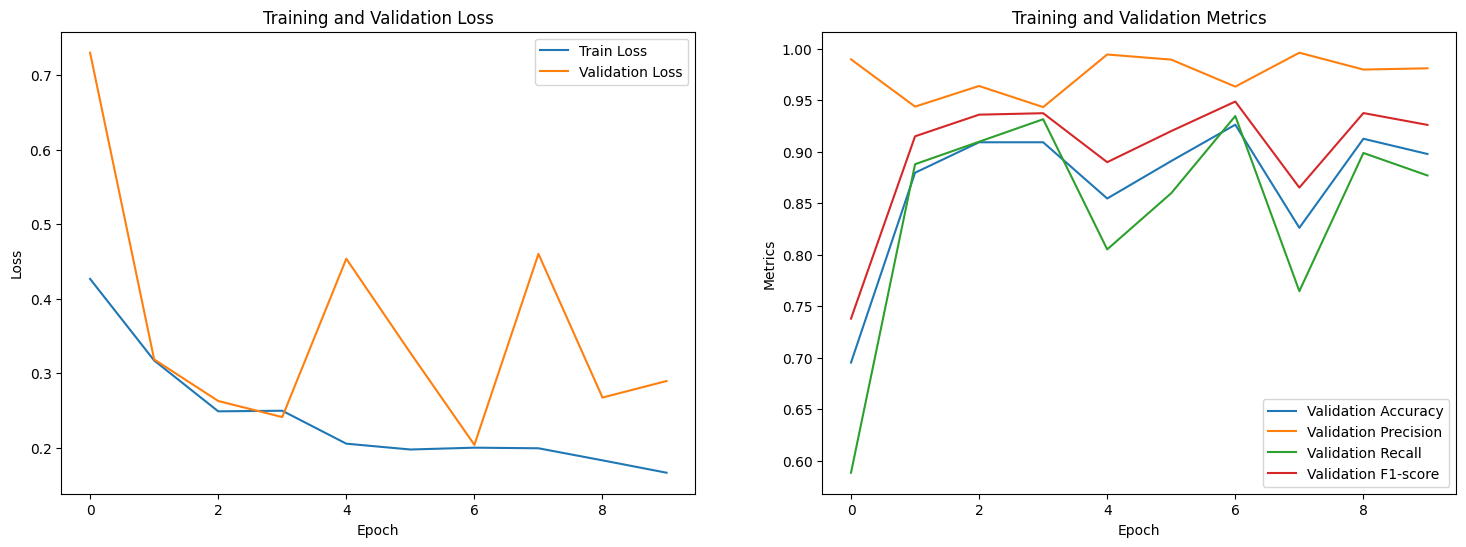

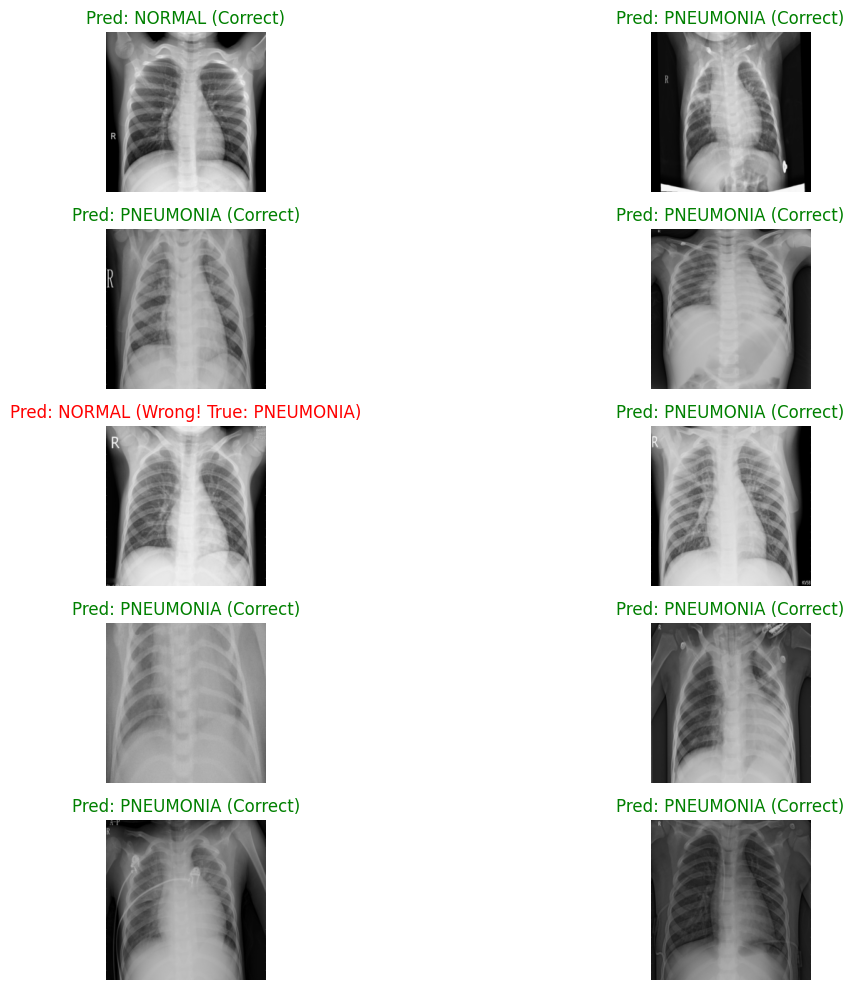

In [35]:
# 모델 학습
print("--- 학습 시작 ---")
history_ncnn = train_new(new_model, train_loader_weighted, new_val_loader, new_loss_fn, new_optimizer, num_epochs = 10)
print("--- 학습 완료 ---")

# 모델 평가
print("\n--- NewCNN 모델 평가 ---")
test_loss_ncnn, test_acc_ncnn, test_precision_ncnn, test_recall_ncnn, test_f1_ncnn = evaluate(new_model, new_test_loader, new_loss_fn)

print(f"Test Loss: {test_loss_ncnn:.4f}")
print(f"Test Accuracy: {test_acc_ncnn:.4f}")
print(f"Test Precision: {test_precision_ncnn:.4f}")
print(f"Test Recall: {test_recall_ncnn:.4f}")
print(f"Test F1-score: {test_f1_ncnn:.4f}")

# 시각화
plot_training_history(history_ncnn)
visualize_predictions(new_model, new_test_loader, class_names, num_images = 10)

### 새로운 Custom CNN 모델 실험 결과
- Test Loss: 0.2286
- Test Accuracy: 0.9134
- Test Precision: 0.9896
- Test Recall: 0.8908
- Test F1-score: 0.9376
- 데이터를 정제 한 것만으로 성능이 비약적으로 향상됐다
- Custom CNN 모델도 꽤 좋은 성능을 보여준다
- 정밀도가 특히 높게 나왔다
- Recall 점수가 조금 낮은 편인데 재현율이 중요한 의료 영상 진단에선 이 모델은 조금 아쉬운 것 같다

## 전이 학습(feature extraction)

In [50]:
# 모델 정의 (ResNet18 Feature Extraction)
model_fe = models.resnet18(weights='ResNet18_Weights.DEFAULT')

# 분류기를 제외한 파라미터 동결
for param in model_fe.parameters():
    param.requires_grad = False

# 새로운 분류기 교체
num_features = model_fe.fc.in_features
model_fe.fc = nn.Linear(num_features, num_classes)
model_fe = model_fe.to(device)

# 손실 함수 및 옵티마이저 정의
# Feature Extraction에서는 분류기 파라미터만 학습하므로, 비교적 높은 학습률을 사용해도 괜찮다
loss_fn_fe = nn.CrossEntropyLoss()
optimizer_fe = optim.Adam(model_fe.parameters(), lr = 0.001)

--- 학습 시작 ---
Epoch 1/10 | Train Loss: 0.4257, Acc: 0.8121 | Val Loss: 0.5245, Acc: 0.7759, F1: 0.8204
Epoch 2/10 | Train Loss: 0.3123, Acc: 0.8773 | Val Loss: 0.4105, Acc: 0.8385, F1: 0.8776
Epoch 3/10 | Train Loss: 0.2766, Acc: 0.8956 | Val Loss: 0.3154, Acc: 0.8862, F1: 0.9176
Epoch 4/10 | Train Loss: 0.2870, Acc: 0.8817 | Val Loss: 0.2438, Acc: 0.9181, F1: 0.9428
Epoch 5/10 | Train Loss: 0.2651, Acc: 0.8975 | Val Loss: 0.2328, Acc: 0.9215, F1: 0.9457
Epoch 6/10 | Train Loss: 0.2639, Acc: 0.8934 | Val Loss: 0.2975, Acc: 0.8885, F1: 0.9194
Epoch 7/10 | Train Loss: 0.2548, Acc: 0.9039 | Val Loss: 0.2274, Acc: 0.9283, F1: 0.9504
Epoch 8/10 | Train Loss: 0.2247, Acc: 0.9114 | Val Loss: 0.2681, Acc: 0.9078, F1: 0.9345
Epoch 9/10 | Train Loss: 0.2338, Acc: 0.9061 | Val Loss: 0.2420, Acc: 0.9238, F1: 0.9468
Epoch 10/10 | Train Loss: 0.2457, Acc: 0.8997 | Val Loss: 0.2549, Acc: 0.9135, F1: 0.9389
--- 학습 완료 ---

--- Feature Extraction 모델 평가 ---
Test Loss: 0.2393
Test Accuracy: 0.9123
Test Pr

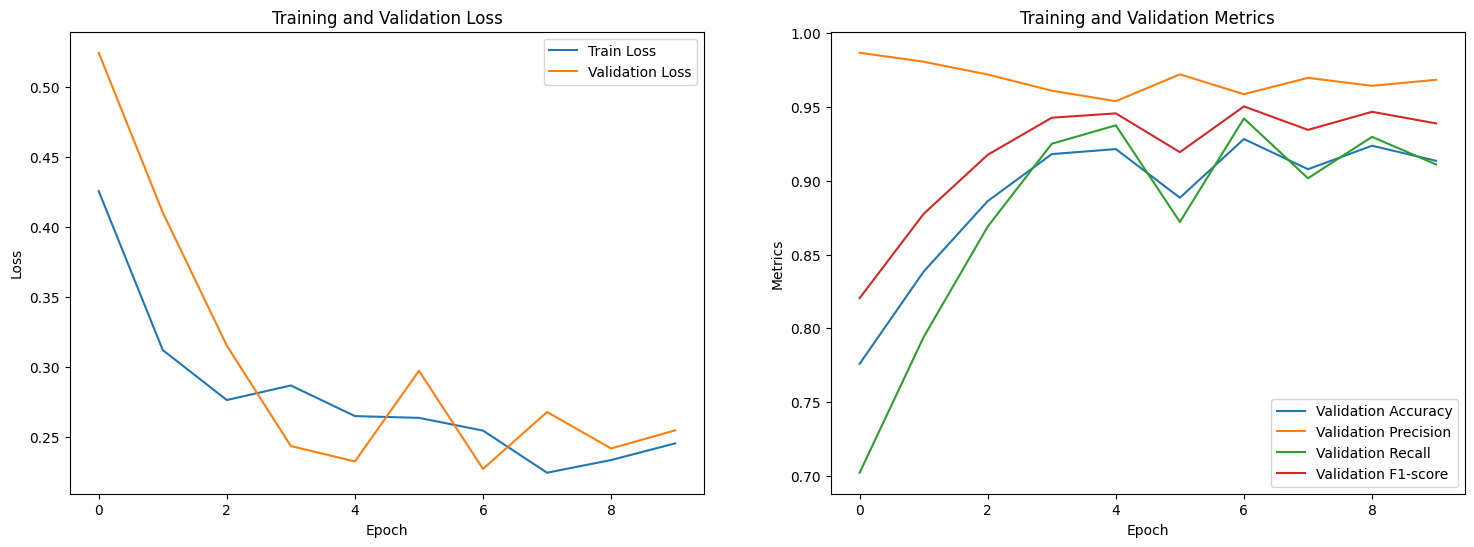

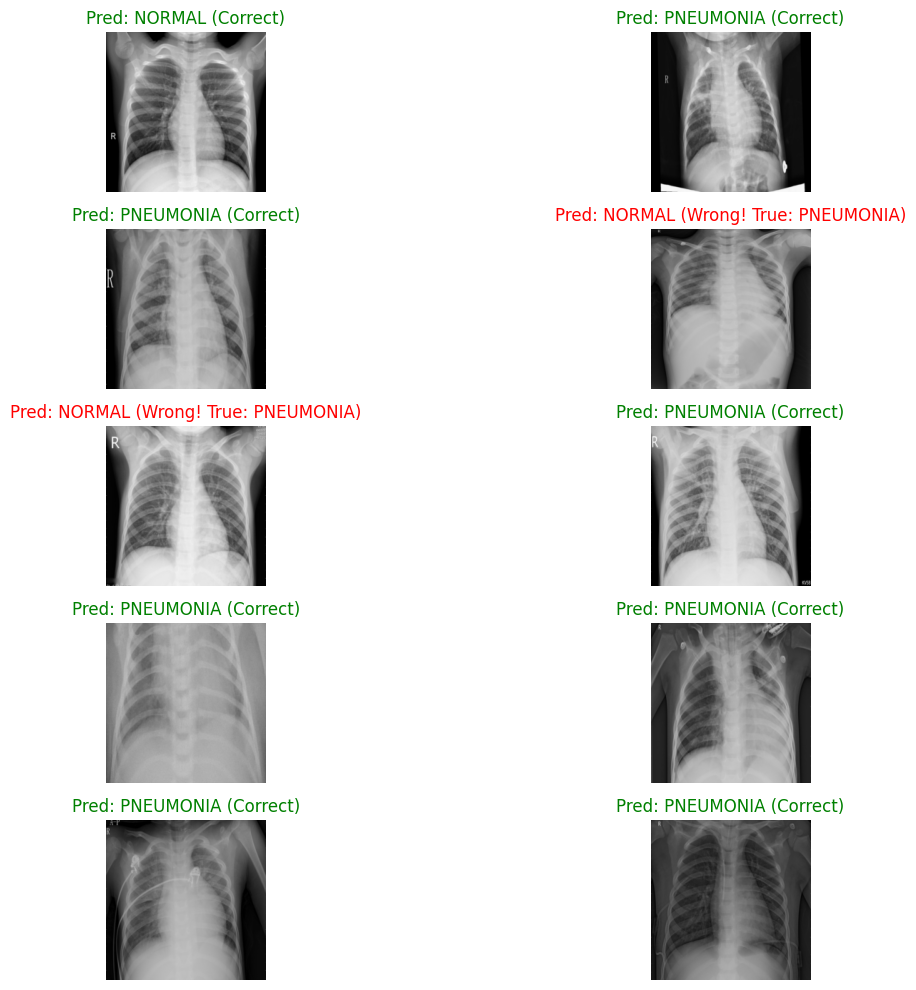

In [51]:
# 모델 학습
print("--- 학습 시작 ---")
history_fe = train_new(model_fe, train_loader_weighted, new_val_loader, loss_fn_fe, optimizer_fe, num_epochs = 10)
print("--- 학습 완료 ---")

# 모델 평가
print("\n--- Feature Extraction 모델 평가 ---")
test_loss_fe, test_acc_fe, test_precision_fe, test_recall_fe, test_f1_fe = evaluate(model_fe, new_test_loader, loss_fn_fe)

print(f"Test Loss: {test_loss_fe:.4f}")
print(f"Test Accuracy: {test_acc_fe:.4f}")
print(f"Test Precision: {test_precision_fe:.4f}")
print(f"Test Recall: {test_recall_fe:.4f}")
print(f"Test F1-score: {test_f1_fe:.4f}")

# 시각화
plot_training_history(history_fe)
visualize_predictions(model_fe, new_test_loader, class_names, num_images = 10)

### 전이 학습 (feature extraction) 실험 결과
- Test Loss: 0.2393
- Test Accuracy: 0.9123
- Test Precision: 0.9812
- Test Recall: 0.8970
- Test F1-score: 0.9372
- 분류기만 교체한 전이 학습 모델도 데이터를 정제하고 나니 엄청나게 성능이 좋아졌다
- 역시 Recall 점수는 조금 낮은 편이다 재현율이 중요한 의료 영상 진단에선 이 모델은 조금 아쉬운 것 같다
- 분류기만 교체한 전이 학습 모델은 CNN 모델과 거의 비슷한 성능을 보여주는 것 같다
- 그래프를 보면 Recall 점수가 오르면 Precision 점수가 떨어지고 Precision 점수가 오르면 Recall 점수가 떨어지는 경향이 있는걸 눈으로 확인할 수 있는 것 같다

## 전이 학습 (partial fine-tuning)

In [52]:
# 모델 정의 (ResNet18 Partial Fine-Tuning)
model_pft = models.resnet18(weights='ResNet18_Weights.DEFAULT')

# layer4와 fc를 제외한 파라미터 동결
for name, param in model_pft.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# 새로운 분류기 교체
num_features = model_pft.fc.in_features
model_pft.fc = nn.Linear(num_features, num_classes)
model_pft = model_pft.to(device)

# 학습될 파라미터만 필터링하여 옵티마이저에 전달
params_to_update = filter(lambda p: p.requires_grad, model_pft.parameters())
print("학습되는 파라미터:")
for name, param in model_pft.named_parameters():
    if param.requires_grad:
        print(name)

# 손실 함수 및 옵티마이저 정의
loss_fn_pft = nn.CrossEntropyLoss()
optimizer_pft = optim.Adam(params_to_update, lr = 0.001) # Feature-extraction과 동일한 학습률 사용

학습되는 파라미터:
layer4.0.conv1.weight
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.conv2.weight
layer4.0.bn2.weight
layer4.0.bn2.bias
layer4.0.downsample.0.weight
layer4.0.downsample.1.weight
layer4.0.downsample.1.bias
layer4.1.conv1.weight
layer4.1.bn1.weight
layer4.1.bn1.bias
layer4.1.conv2.weight
layer4.1.bn2.weight
layer4.1.bn2.bias
fc.weight
fc.bias



--- 모델 학습 시작 ---
Epoch 1/10 | Train Loss: 0.1867, Acc: 0.9305 | Val Loss: 0.1906, Acc: 0.9431, F1: 0.9603
Epoch 2/10 | Train Loss: 0.1467, Acc: 0.9556 | Val Loss: 0.2545, Acc: 0.9272, F1: 0.9481
Epoch 3/10 | Train Loss: 0.1163, Acc: 0.9617 | Val Loss: 0.2725, Acc: 0.9238, F1: 0.9453
Epoch 4/10 | Train Loss: 0.0954, Acc: 0.9666 | Val Loss: 0.2008, Acc: 0.9613, F1: 0.9737
Epoch 5/10 | Train Loss: 0.0921, Acc: 0.9685 | Val Loss: 0.1899, Acc: 0.9386, F1: 0.9566
Epoch 6/10 | Train Loss: 0.1174, Acc: 0.9671 | Val Loss: 0.2020, Acc: 0.9488, F1: 0.9641
Epoch 7/10 | Train Loss: 0.0991, Acc: 0.9715 | Val Loss: 0.3060, Acc: 0.9170, F1: 0.9399
Epoch 8/10 | Train Loss: 0.1098, Acc: 0.9580 | Val Loss: 0.1649, Acc: 0.9579, F1: 0.9710
Epoch 9/10 | Train Loss: 0.0792, Acc: 0.9695 | Val Loss: 0.1725, Acc: 0.9590, F1: 0.9717
Epoch 10/10 | Train Loss: 0.0572, Acc: 0.9766 | Val Loss: 0.2983, Acc: 0.9488, F1: 0.9640
--- 학습 완료 ---

--- Partial Fine-Tuning 모델 평가 ---
Test Loss: 0.1686
Test Accuracy: 0.9522
Te

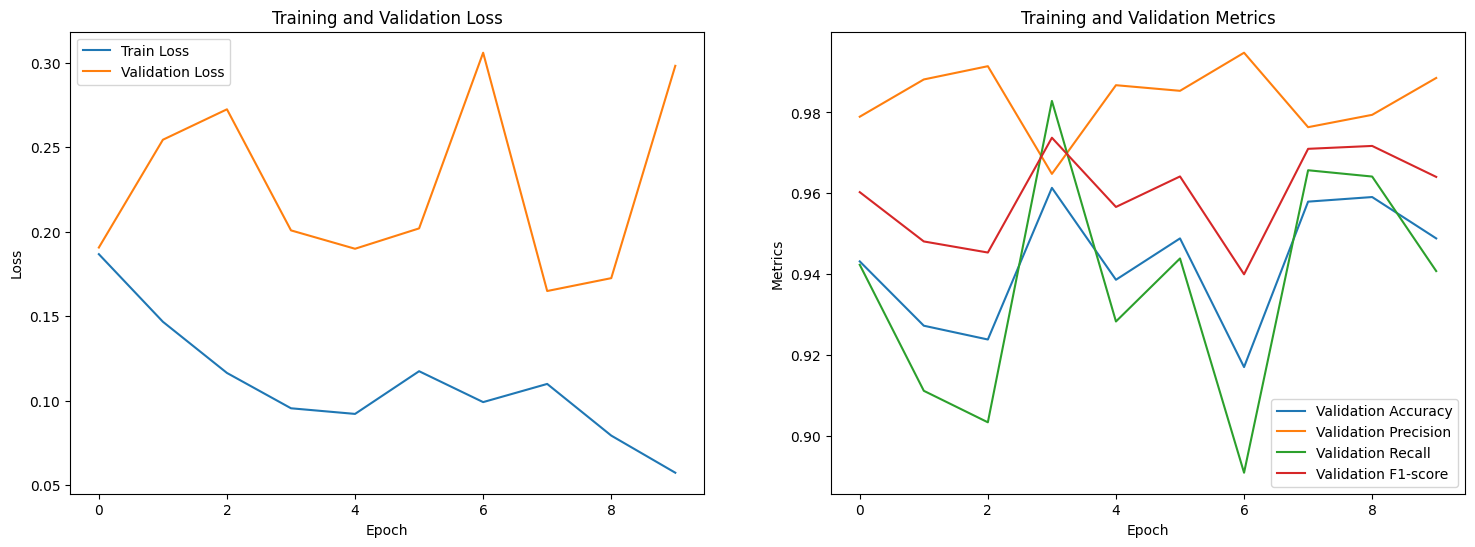

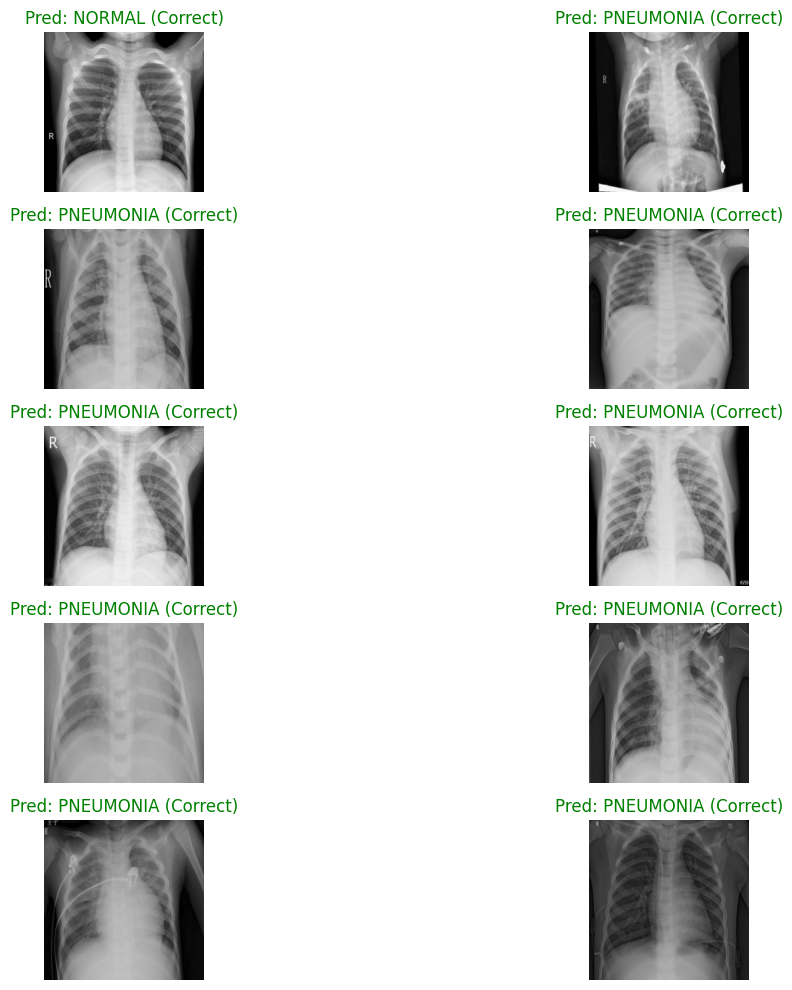

In [53]:
# 모델 학습
print("\n--- 모델 학습 시작 ---")
history_pft = train_new(model_pft, train_loader_weighted, new_val_loader, loss_fn_pft, optimizer_pft, num_epochs=10)
print("--- 학습 완료 ---")

# 4. 모델 평가
print("\n--- Partial Fine-Tuning 모델 평가 ---")
test_loss_pft, test_acc_pft, test_precision_pft, test_recall_pft, test_f1_pft = evaluate(model_pft, new_test_loader, loss_fn_pft)

print(f"Test Loss: {test_loss_pft:.4f}")
print(f"Test Accuracy: {test_acc_pft:.4f}")
print(f"Test Precision: {test_precision_pft:.4f}")
print(f"Test Recall: {test_recall_pft:.4f}")
print(f"Test F1-score: {test_f1_pft:.4f}")

# 시각화
plot_training_history(history_pft)
visualize_predictions(model_pft, new_test_loader, class_names, num_images = 10)

### 전이 학습 (partial fine-tuning) 실험 결과
- Test Loss: 0.1686
- Test Accuracy: 0.9522
- Test Precision: 0.9934
- Test Recall: 0.9407
- Test F1-score: 0.9663
- 전이 학습의 진가가 나타나기 시작하는 것 같다
- 정밀도는 거의 1에 가까워졌고 재현율도 꽤 많이 올라갔다

## 전이 학습 (full fine-tuning)

In [66]:
# 모델 정의 (ResNet18 Full Fine-Tuning)
model_ff = models.resnet18(weights = 'ResNet18_Weights.DEFAULT')

# 모든 파라미터를 학습 가능하도록 설정
for param in model_ff.parameters():
    param.requires_grad = True

# 분류기 교체
num_features = model_ff.fc.in_features
model_ff.fc = nn.Linear(num_features, num_classes)
model_ff = model_ff.to(device)

# 손실 함수 및 옵티마이저 정의
# Full Fine-Tuning 시에는 일반적으로 낮은 학습률(learning rate)을 사용
loss_fn_ff = nn.CrossEntropyLoss()
optimizer_ff = optim.Adam(model_ff.parameters(), lr = 0.00001)


--- 모델 학습 시작 ---
Epoch 1/10 | Train Loss: 0.3061, Acc: 0.8836 | Val Loss: 0.2844, Acc: 0.8976, F1: 0.9255
Epoch 2/10 | Train Loss: 0.1638, Acc: 0.9393 | Val Loss: 0.1700, Acc: 0.9443, F1: 0.9611
Epoch 3/10 | Train Loss: 0.1190, Acc: 0.9595 | Val Loss: 0.1682, Acc: 0.9408, F1: 0.9585
Epoch 4/10 | Train Loss: 0.0973, Acc: 0.9654 | Val Loss: 0.1384, Acc: 0.9568, F1: 0.9700
Epoch 5/10 | Train Loss: 0.0928, Acc: 0.9651 | Val Loss: 0.1430, Acc: 0.9522, F1: 0.9667
Epoch 6/10 | Train Loss: 0.0916, Acc: 0.9656 | Val Loss: 0.1474, Acc: 0.9511, F1: 0.9658
Epoch 7/10 | Train Loss: 0.0682, Acc: 0.9739 | Val Loss: 0.1247, Acc: 0.9647, F1: 0.9756
Epoch 8/10 | Train Loss: 0.0742, Acc: 0.9732 | Val Loss: 0.1454, Acc: 0.9568, F1: 0.9698
Epoch 9/10 | Train Loss: 0.0602, Acc: 0.9771 | Val Loss: 0.1617, Acc: 0.9454, F1: 0.9617
Epoch 10/10 | Train Loss: 0.0703, Acc: 0.9798 | Val Loss: 0.1264, Acc: 0.9693, F1: 0.9789
--- 학습 완료 ---

--- Full Fine-Tuning 모델 평가 ---
Test Loss: 0.0786
Test Accuracy: 0.9761
Test 

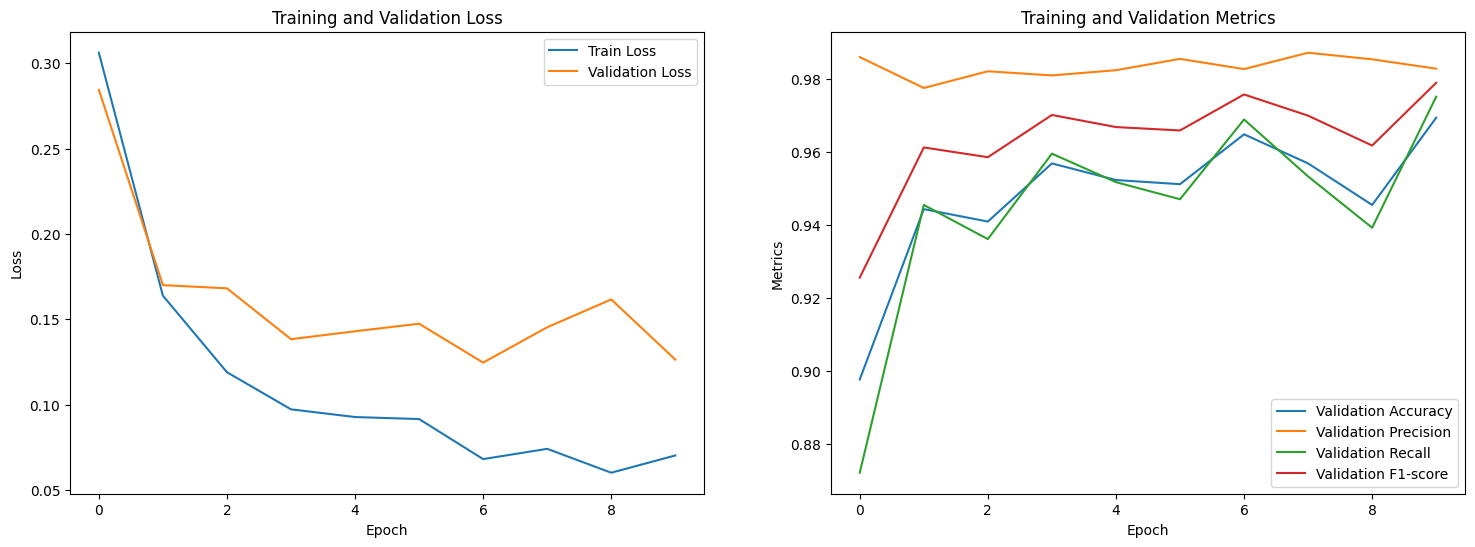

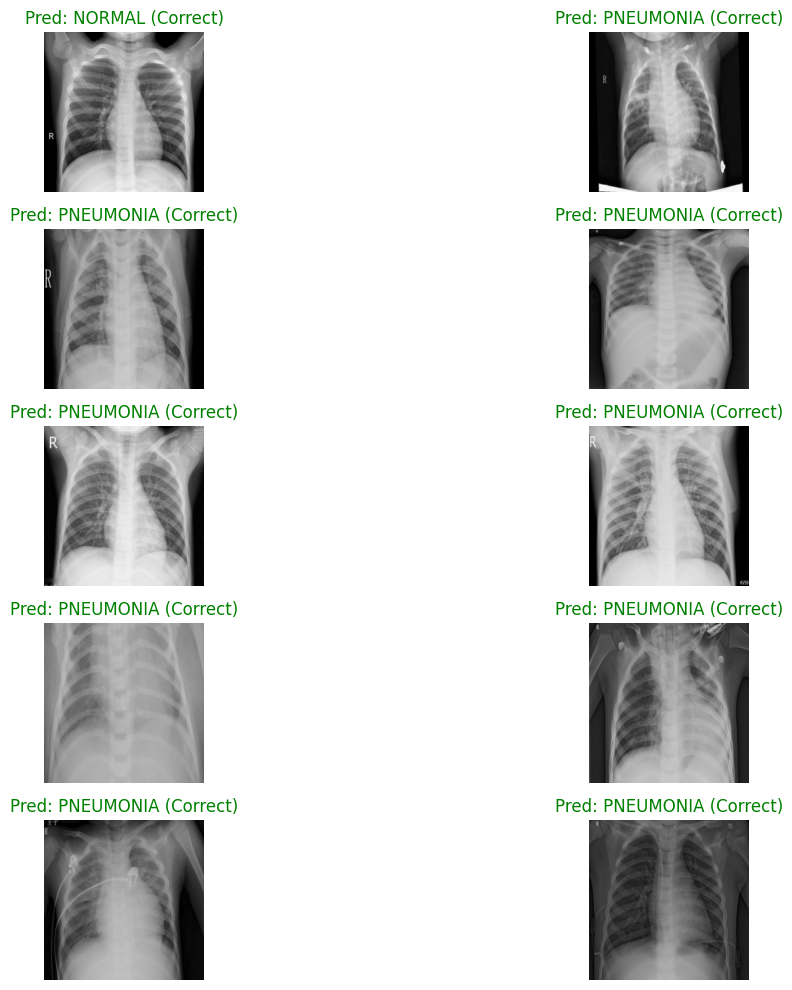

In [67]:
# 모델 학습
print("\n--- 모델 학습 시작 ---")
history_ff = train_new(model_ff, train_loader_weighted, new_val_loader, loss_fn_ff, optimizer_ff, num_epochs=10)
print("--- 학습 완료 ---")

# 4. 모델 평가
print("\n--- Full Fine-Tuning 모델 평가 ---")
test_loss_ff, test_acc_ff, test_precision_ff, test_recall_ff, test_f1_ff = evaluate(model_ff, new_test_loader, loss_fn_ff)

print(f"Test Loss: {test_loss_ff:.4f}")
print(f"Test Accuracy: {test_acc_ff:.4f}")
print(f"Test Precision: {test_precision_ff:.4f}")
print(f"Test Recall: {test_recall_ff:.4f}")
print(f"Test F1-score: {test_f1_ff:.4f}")

# 시각화
plot_training_history(history_ff)
visualize_predictions(model_ff, new_test_loader, class_names, num_images = 10)

### 전이학습 (full fine-tuning) 실험 결과
- Test Loss: 0.0786
- Test Accuracy: 0.9761
- Test Precision: 0.9874
- Test Recall: 0.9797
- Test F1-score: 0.9836
- 전체 미세 조정한 전이 학습 모델은 점수가 가장 좋아진다
- accuracy 점수도 가장 좋고 precision과 recall 그리고 F1 점수도 모두 좋다 전체적으로 가장 밸런스 있게 좋은 성능을 보여준다
- recall 점수도 0.97로 가장 높은 점수를 기록 해서 이 모델이 의료 영상 진단에 가장 적합한 모델이 된 것 같다

# 모델 저장 및 불러오기 연습
- state_dict 사용
- 가장 성능이 좋았던 full fine-tuning 모델을 저장하고 불러오는 연습을 해본다

In [68]:
# 모델 저장 (state_dict 사용)
Model_Path = '../model_ff_state_dict.pth'
torch.save(model_ff.state_dict(), Model_Path)

print(f"Model saved to {Model_Path}")

Model saved to model_ff_state_dict.pth


In [69]:
# 모델 불러오기 (state_dict 사용)
loaded_model = models.resnet18(weights = 'ResNet18_Weights.DEFAULT')
num_features = loaded_model.fc.in_features
loaded_model.fc = nn.Linear(num_features, num_classes)
loaded_model = loaded_model.to(device)

Model_Path = '../model_ff_state_dict.pth'
loaded_model.load_state_dict(torch.load(Model_Path))

loaded_model.eval()

print('모델 전체 구조 출력')
print(loaded_model)

모델 전체 구조 출력
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inpl

In [70]:
print("\n\n--- 모델 파라미터(state_dict) 상세 정보 ---")
print(f"{'레이어 이름':<40} {'파라미터 텐서 크기'}")
for param_tensor_name in loaded_model.state_dict():
    tensor = loaded_model.state_dict()[param_tensor_name]
    print(f"{param_tensor_name:<40} \t{tensor.size()}")



--- 모델 파라미터(state_dict) 상세 정보 ---
레이어 이름                                   파라미터 텐서 크기
conv1.weight                             	torch.Size([64, 3, 7, 7])
bn1.weight                               	torch.Size([64])
bn1.bias                                 	torch.Size([64])
bn1.running_mean                         	torch.Size([64])
bn1.running_var                          	torch.Size([64])
bn1.num_batches_tracked                  	torch.Size([])
layer1.0.conv1.weight                    	torch.Size([64, 64, 3, 3])
layer1.0.bn1.weight                      	torch.Size([64])
layer1.0.bn1.bias                        	torch.Size([64])
layer1.0.bn1.running_mean                	torch.Size([64])
layer1.0.bn1.running_var                 	torch.Size([64])
layer1.0.bn1.num_batches_tracked         	torch.Size([])
layer1.0.conv2.weight                    	torch.Size([64, 64, 3, 3])
layer1.0.bn2.weight                      	torch.Size([64])
layer1.0.bn2.bias                        	torch.Size([64])
la

In [71]:
# 모델의 총 파라미터 수 계산 및 출력
total_params = sum(p.numel() for p in loaded_model.parameters())
trainable_params = sum(p.numel() for p in loaded_model.parameters() if p.requires_grad)

print(f"\n\n--- 모델 파라미터 요약 ---")
print(f"전체 파라미터 수: {total_params:,} 개")
print(f"학습 가능한 파라미터 수: {trainable_params:,} 개")



--- 모델 파라미터 요약 ---
전체 파라미터 수: 11,177,538 개
학습 가능한 파라미터 수: 11,177,538 개
